In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


# Load data

In [4]:
dataset_dir = 'dataset'
# dataset_dir = '/kaggle/input/an2dl-challenge2'

In [5]:
dataset = np.load(f'{dataset_dir}/training_data.npy')
df = pd.DataFrame(dataset)
df.shape

(48000, 2776)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909


In [7]:
valid_periods = np.load(f'{dataset_dir}/valid_periods.npy')
valid_periods.shape

(48000, 2)

In [8]:
categories = np.load(f'{dataset_dir}/categories.npy')
categories_df = pd.DataFrame(categories, columns=['category'])
categories.shape

(48000,)

# Inspect

In [21]:
def plot_ts(dataset, i, valid_periods=valid_periods):
    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.iloc[i, valid_periods[i][0]:valid_periods[i][1]], label='Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_ts_custom(ts):
    plt.figure(figsize=(8, 17))
    plt.plot(ts, label='Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()
    
def plot_ts_subplots(ts, ax, title=None):
    ax.plot(ts)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    if (title):
        ax.set_title(title)

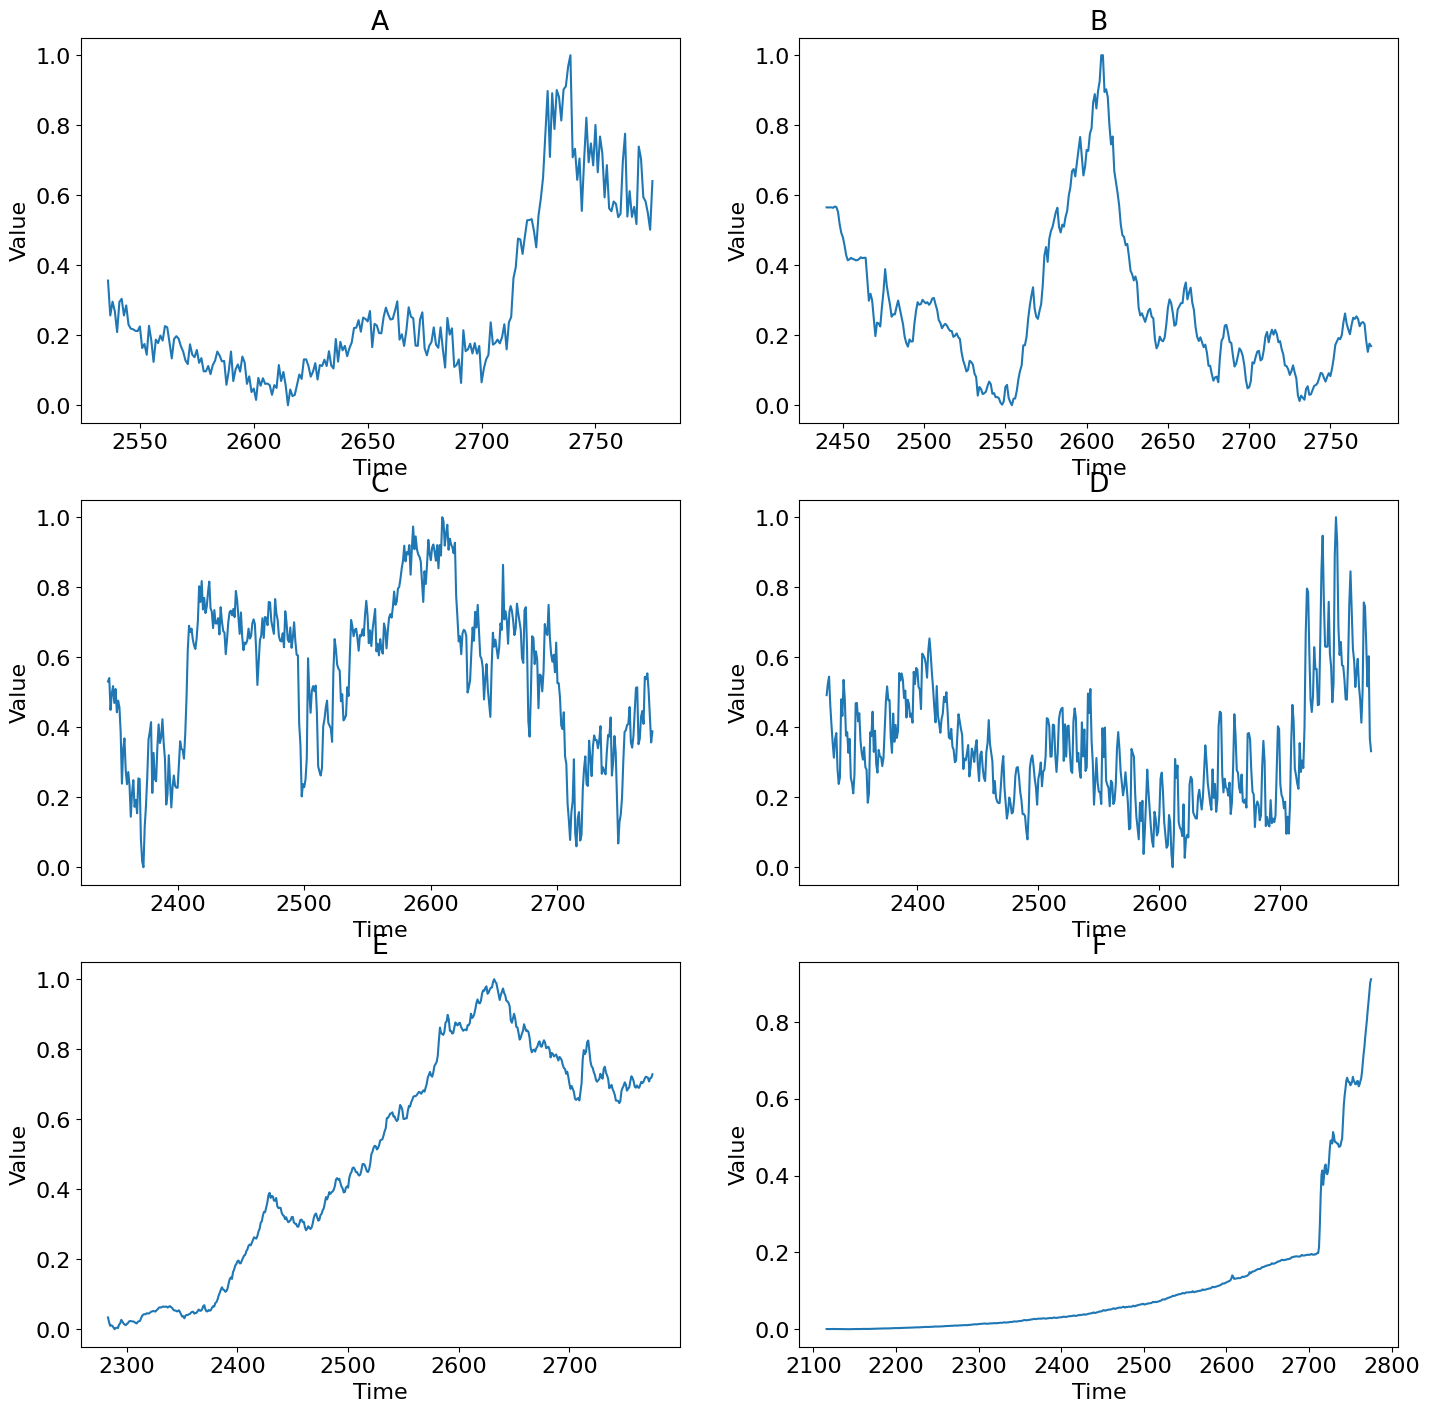

In [24]:

unique_categories, indices_unique_categories = np.unique(categories, return_index=True)

n_cols = 2
n_rows = int(len(unique_categories)/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(17,17))
axes = axs.flatten()
for i, (category, ax) in enumerate(zip(unique_categories, axes)):
    idx = indices_unique_categories[i]
    ts = df.iloc[idx][valid_periods[idx][0]:valid_periods[idx][1]]
    plot_ts_subplots(ts, ax, title=category)
plt.show()

In [30]:
categories_df

,category
0,D
1,D
2,D
3,D
4,D
...,...
47995,F
47996,F
47997,F
47998,F


In [65]:
category_counts = categories_df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts.sort_values(by='count', ascending=False, inplace=True)

category_counts

,category,count
0,B,10987
1,E,10975
2,C,10017
3,D,10016
4,A,5728
5,F,277


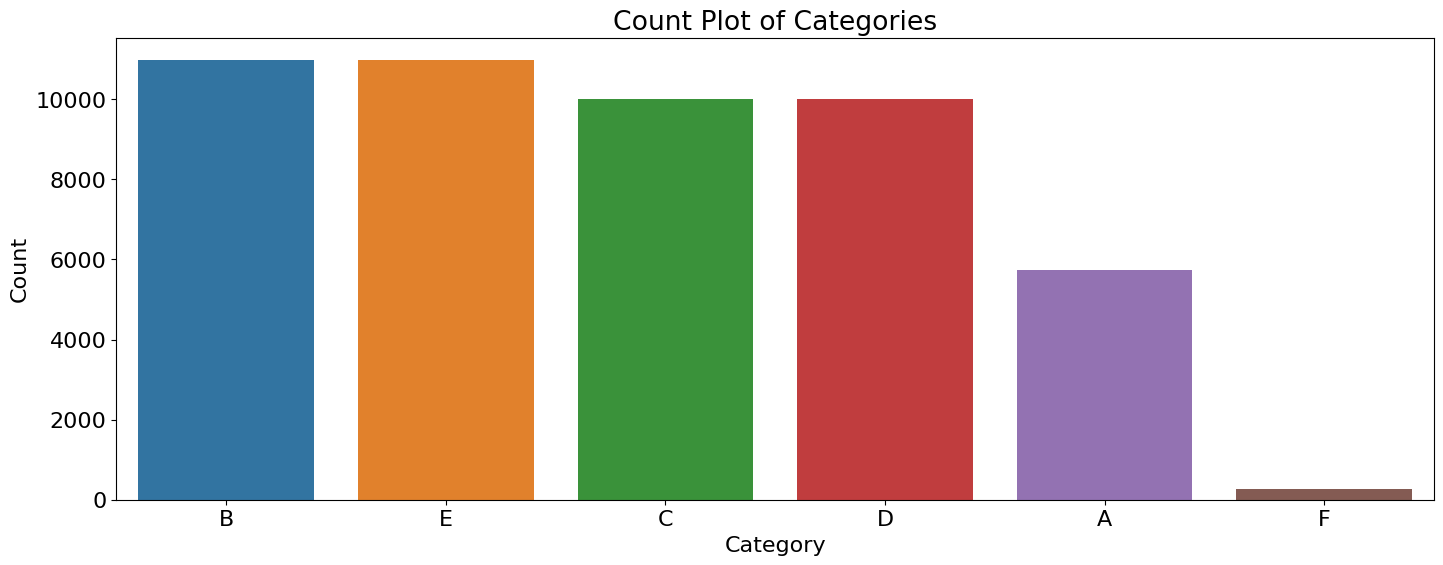

In [67]:
# plt.figure(figsize=(17,5))
# sns.countplot(x='category', data = categories_df, order=categories_df['category'].value_counts().index)
# plt.title('Category count')
# plt.show()

# Set the size of the figure
plt.figure(figsize=(17, 6))

# Create a countplot
sns.barplot(x='category', y='count', data=category_counts, order=category_counts['category'])

# Set title and labels
plt.title('Count Plot of Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Show the plot
plt.show()

In [68]:
def inspect_univariate(X, y,telescope, pred=None, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    plt.plot(np.arange(0, len(X[idx,:])), X[idx,:])
    plt.scatter(np.arange(len(X[idx,:]), len(X[idx,:])+telescope), y[idx,:], color='orange')
    if (pred):
        plt.plot(np.arange(len(X[idx,:]), len(X[idx,:])+telescope), pred[idx,:], color='green')
    plt.show()

# Build model

In [69]:
df = df.astype('float32')

In [71]:
df_with_info = df.copy()
df_with_info['non_zero_counts'] = df_with_info.apply(lambda x: x.astype(bool).sum(), axis=1)
df_with_info['category'] = categories
df_with_info = df_with_info[['non_zero_counts', 'category']]
df_with_info = df_with_info.groupby('category').agg(['mean', 'max', 'min', 'std', 'count'])
df_with_info

non_zero_counts                             
                    mean   max min         std  count
category                                             
A             277.088862  1939  46  109.272073   5728
B             164.779831  1483  11  116.078233  10987
C             206.831287  2707  30  146.186424  10017
D             216.013478  2639  41  148.932680  10016
E             162.104237  2776  41  127.792750  10975
F             193.537906  1064  23  153.358948    277

In [72]:
df_with_count = df.copy()
df_with_count['non_zero_counts'] = df_with_count.apply(lambda x: x.astype(bool).sum(), axis=1)
df_with_count['category'] = categories
df_with_count = df_with_count[['non_zero_counts', 'category']]
df_with_count = df_with_count.groupby(['non_zero_counts', 'category']).size().reset_index(name='count')

# Stationarity

In [73]:
def test_stationarity(timeseries, plot=False, window=30):
    if (plot):
        rolmean = timeseries.rolling(window=window).mean()
        rolstd = timeseries.rolling(window=window).std()

        plt.figure(figsize=(14,5))
        sns.despine(left=True)
        plt.plot(timeseries, color='blue',label='Original')
        plt.plot(rolmean, color='red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')

        plt.legend(loc='best'); 
        plt.title('Rolling Mean & Standard Deviation')
        plt.show()
    
    dftest = adfuller(timeseries)
    
    return dftest

def check_stationarity(ts, significance_level = 0.05, critical_value_threshold=10):
    adfuller_test = adfuller(ts)
    adfuller_critical_val = adfuller_test[4][f'{critical_value_threshold}%']
        
    is_adfuller_rejected = (adfuller_test[1] < significance_level) & (adfuller_test[0] < adfuller_critical_val)
    
    
    return is_adfuller_rejected, adfuller_test[2]

In [74]:
def build_sequences(df, window=200, stride=10, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset = []
    labels = []
    for index, row in df.iterrows():
        temp = row.values[valid_periods[index][0]:valid_periods[index][1]]
        padding_check = len(temp)%window
        if(padding_check != 0):
            # Compute padding length
            padding_len = window - padding_check
            padding = np.zeros((padding_len), dtype='float32')
            temp = np.concatenate((temp, padding))
            assert len(temp) % window == 0
            
        
        for idx in np.arange(0,len(temp)-window-telescope,stride):
            dataset.append(temp[idx:idx+window])
            labels.append(temp[idx+window:idx+window+telescope])
        
    dataset = np.expand_dims(np.array(dataset), axis=2)
    labels = np.expand_dims(np.array(labels), axis=2)
    
    return dataset, labels

In [75]:
def get_df_category(category, df=df, categories=categories, drop_useless=True):
    df_tmp = df.copy()
    df_tmp['non_zero_counts'] = df_tmp.apply(lambda x: x.astype(bool).sum(), axis=1)
    df_tmp['category'] = categories
    df_tmp = df_tmp[(df_tmp['category'] == category)]
    if (drop_useless):
        df_tmp.drop(columns=['non_zero_counts', 'category'], inplace=True)
    return df_tmp

In [76]:
from sklearn.utils import shuffle
df_tmp = get_df_category('B')
df_tmp = shuffle(df_tmp)

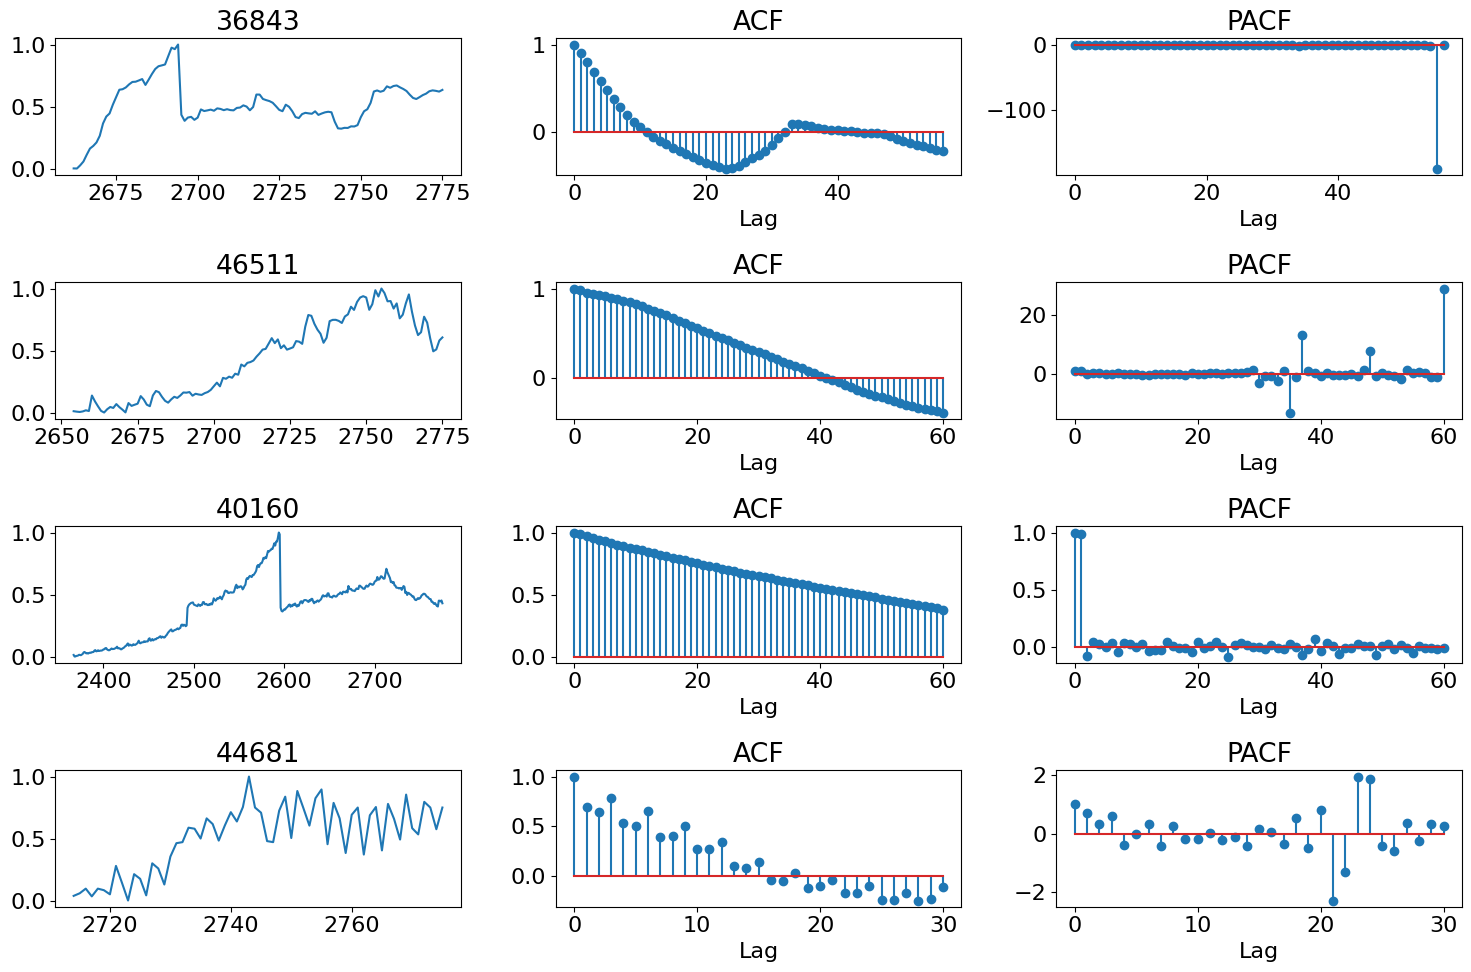

In [78]:
n_rows = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 10))

for i in range(n_rows):
    idx = df_tmp.index[i]
    valid_ts = df.loc[idx][valid_periods[idx][0]:valid_periods[idx][1]]
    max_lags = int(len(valid_ts) * 0.5) - 1
    pacf_result = tsaplots.pacf(valid_ts, nlags=min(60, max_lags))
    acf_result = tsaplots.acf(valid_ts, nlags=min(60, max_lags))
    
    axes[i, 0].plot(valid_ts)
    axes[i, 0].set_title(f'{idx}')
    
    axes[i, 1].stem(acf_result)
    axes[i, 1].set_title('ACF')
    axes[i, 1].set_xlabel('Lag')
    
    axes[i, 2].stem(pacf_result)
    axes[i, 2].set_title('PACF')
    axes[i, 2].set_xlabel('Lag')

plt.tight_layout()
plt.show()


In [79]:

def visualize_stat_results(series, title, ax, statistic='adf'):
    if (statistic == 'adf'):
        result = adfuller(series)
        crit_val_idx = 4
    else:
        result = kpss(series.values, regression='ct')
        crit_val_idx = 3
        
    significance_level = 0.05
    stat = result[0]
    p_val = result[1]
    crit_val_1 = result[crit_val_idx]['1%']
    crit_val_5 = result[crit_val_idx]['5%']
    crit_val_10 = result[crit_val_idx]['10%']

    if (p_val < significance_level) & ((stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(series, ax=ax, color=linecolor)
    ax.set_title(f'{statistic.upper()} Statistic {stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=12)
    ax.set_ylabel(ylabel=title, fontsize=12)

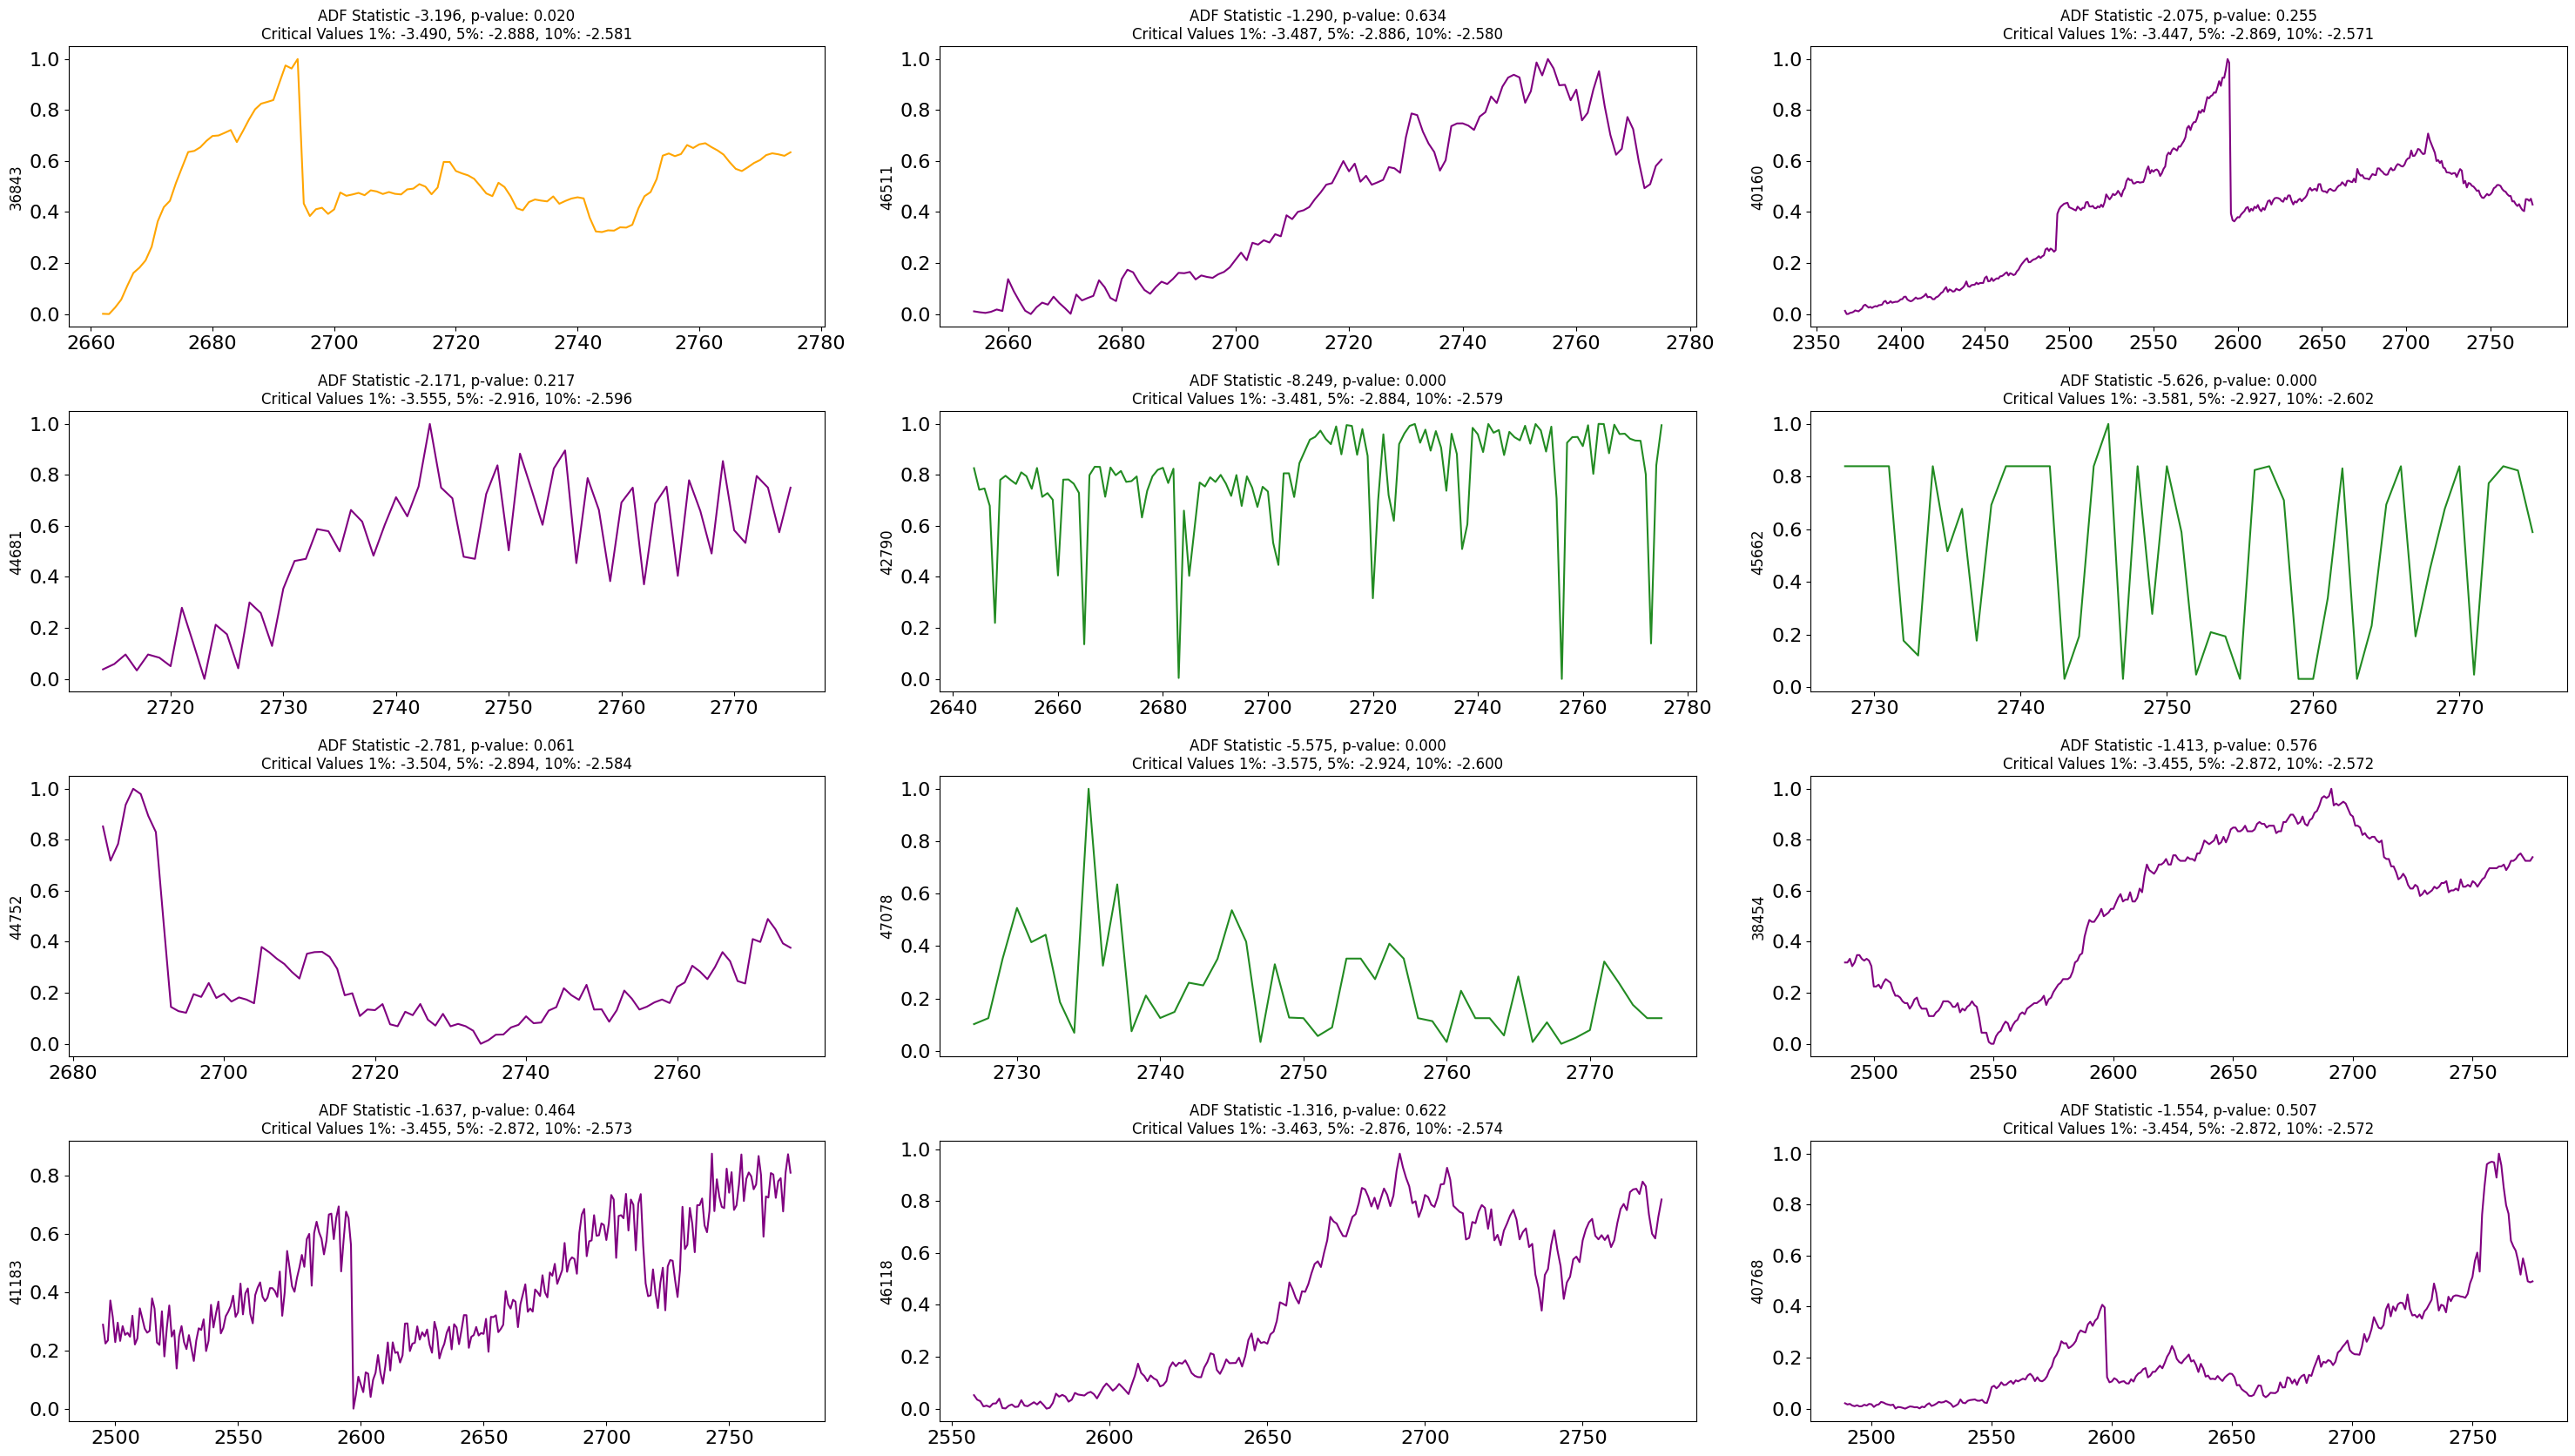

In [80]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(30, 17))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.5)

for (idx, row), ax in zip(df_tmp.iterrows(), axes):
    valid_ts = row[valid_periods[idx][0]:valid_periods[idx][1]]
    visualize_stat_results(valid_ts, idx, ax)
    
plt.tight_layout()
plt.show()


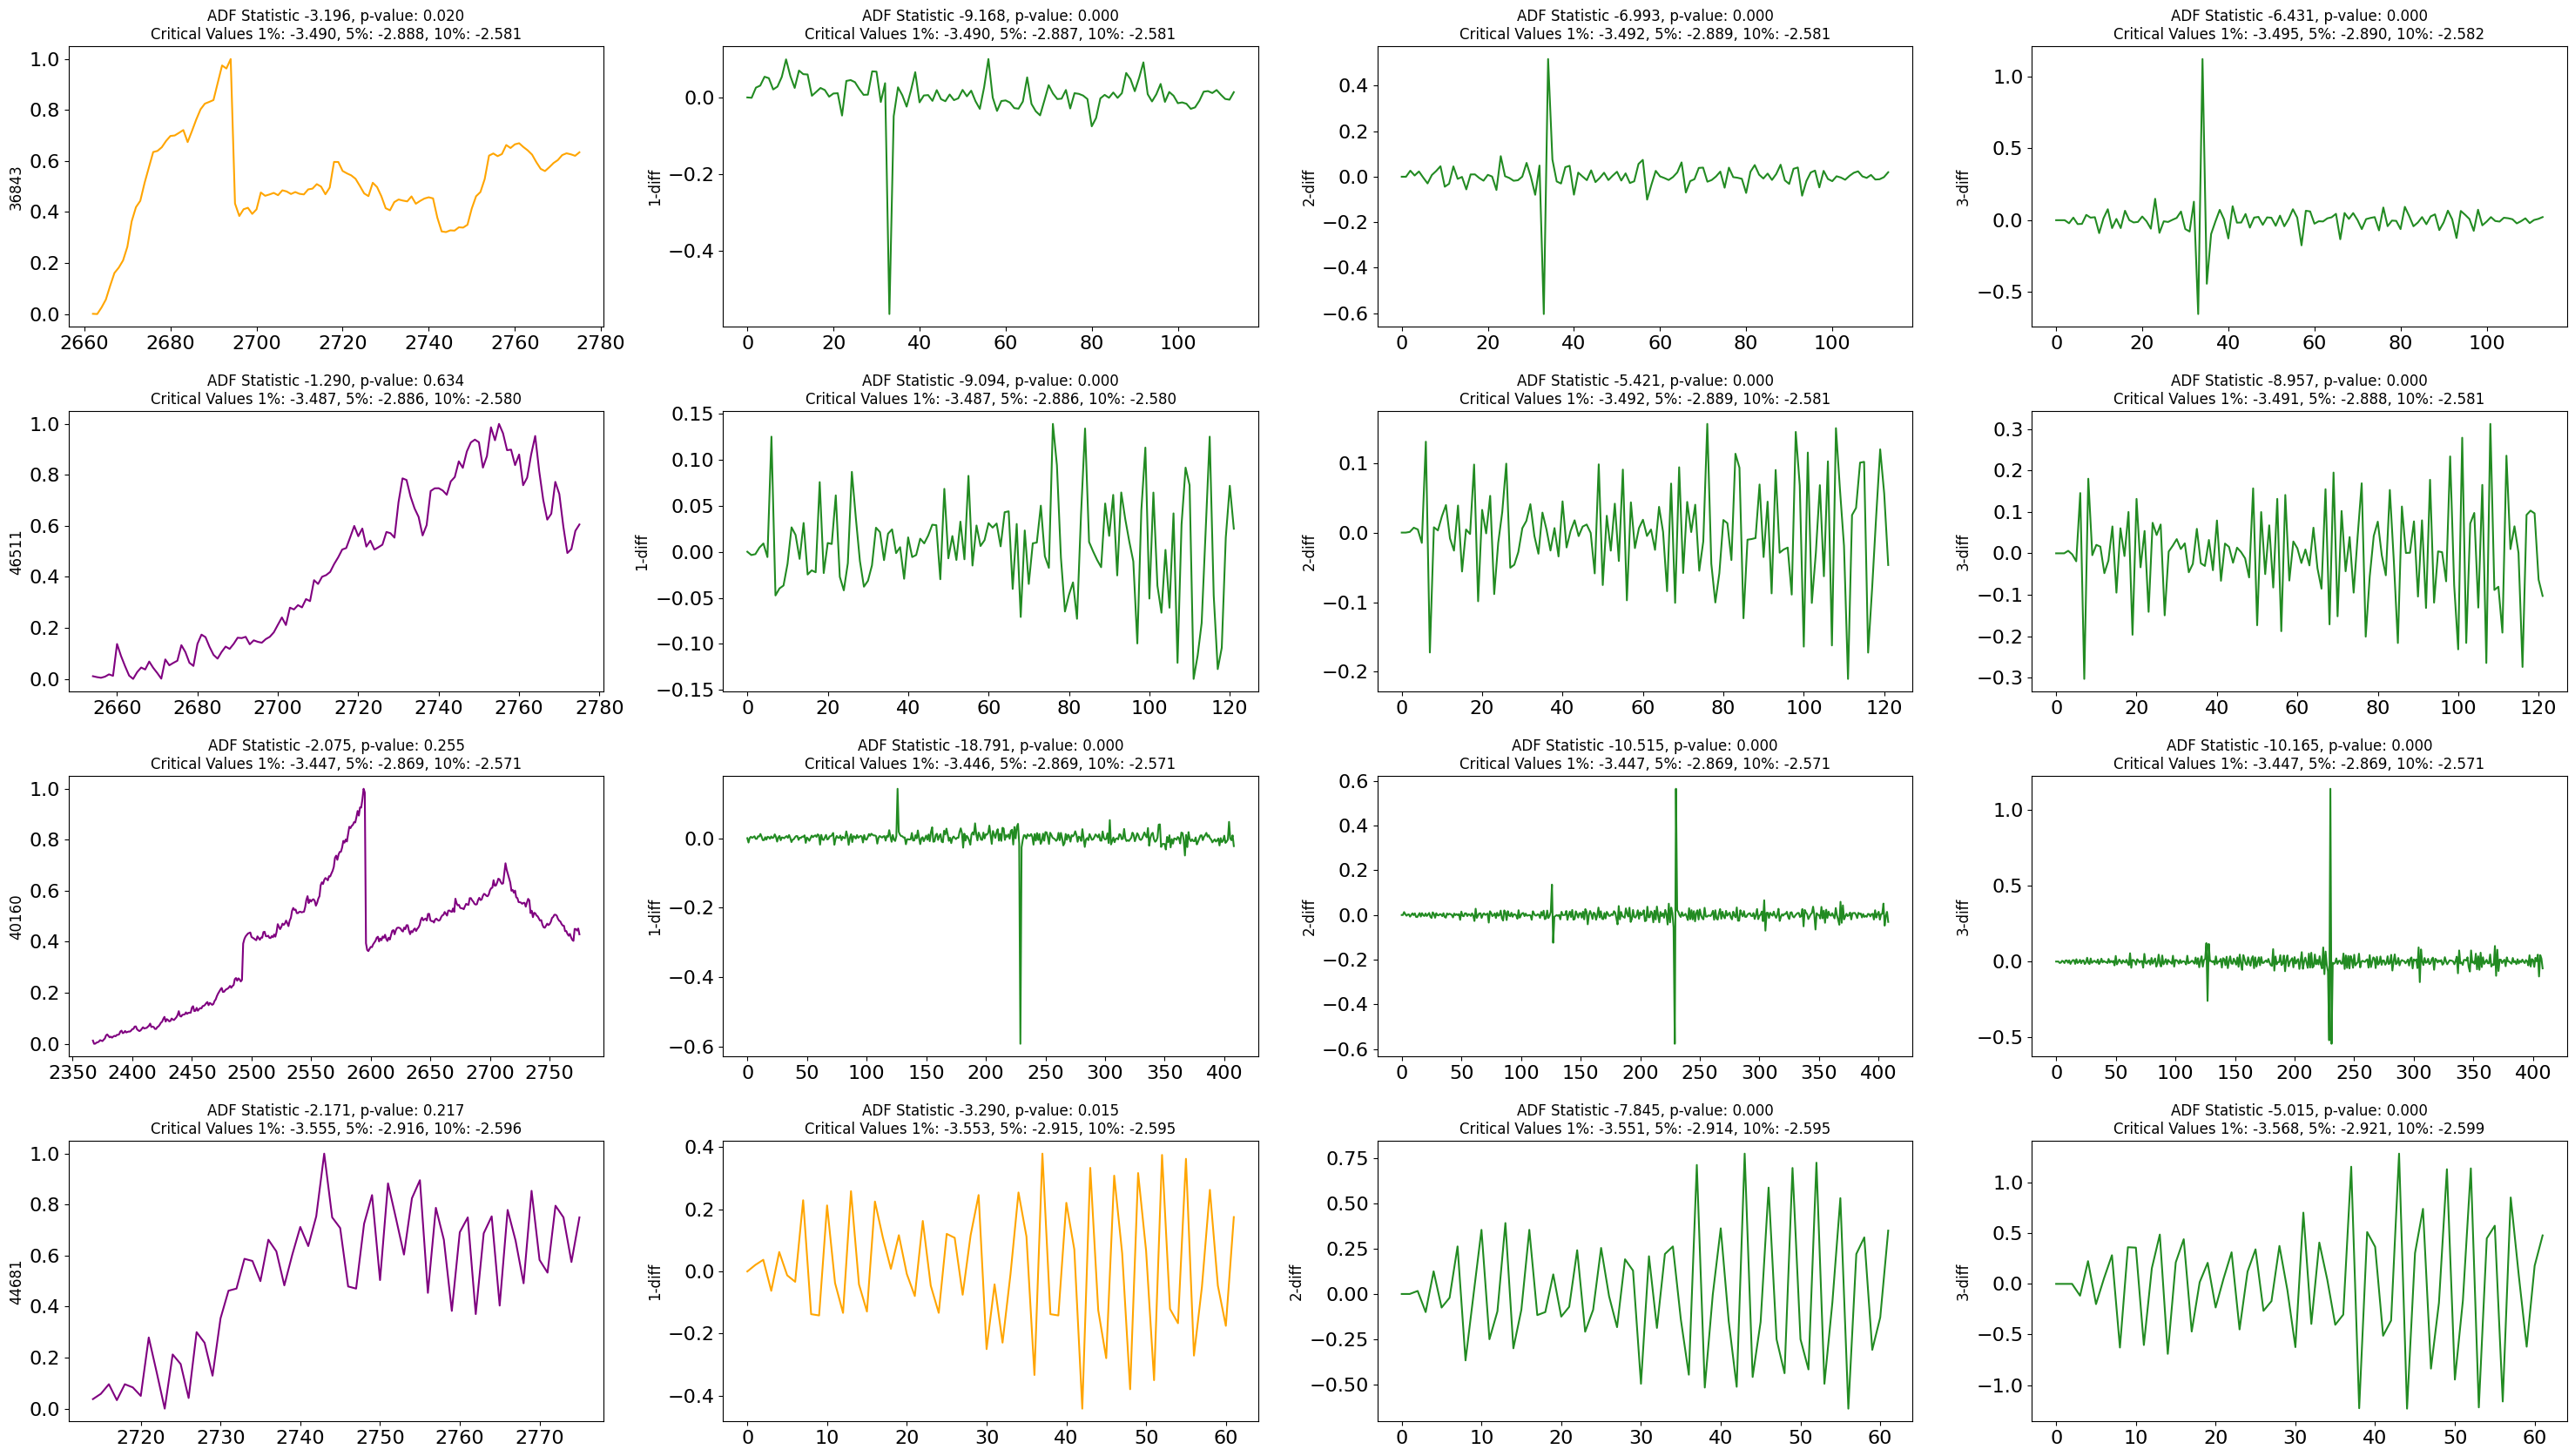

In [81]:
n_rows=4
n_cols=4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 17))
plt.subplots_adjust(hspace=0.5)

for i in range(n_rows):
    idx = df_tmp.index[i]
    row = df_tmp.loc[idx]
    valid_ts = row[valid_periods[idx][0]:valid_periods[idx][1]]
    visualize_stat_results(valid_ts, idx, axes[i, 0])

    for col in range(1, n_cols):
        ts_diff = valid_ts
        for _ in range(col):
            ts_diff = ts_diff.diff().dropna()
        ts_diff = np.append([0]*col, ts_diff)
        title = None
        visualize_stat_results(ts_diff, f'{col}-diff', axes[i, col])
plt.tight_layout()
plt.show()


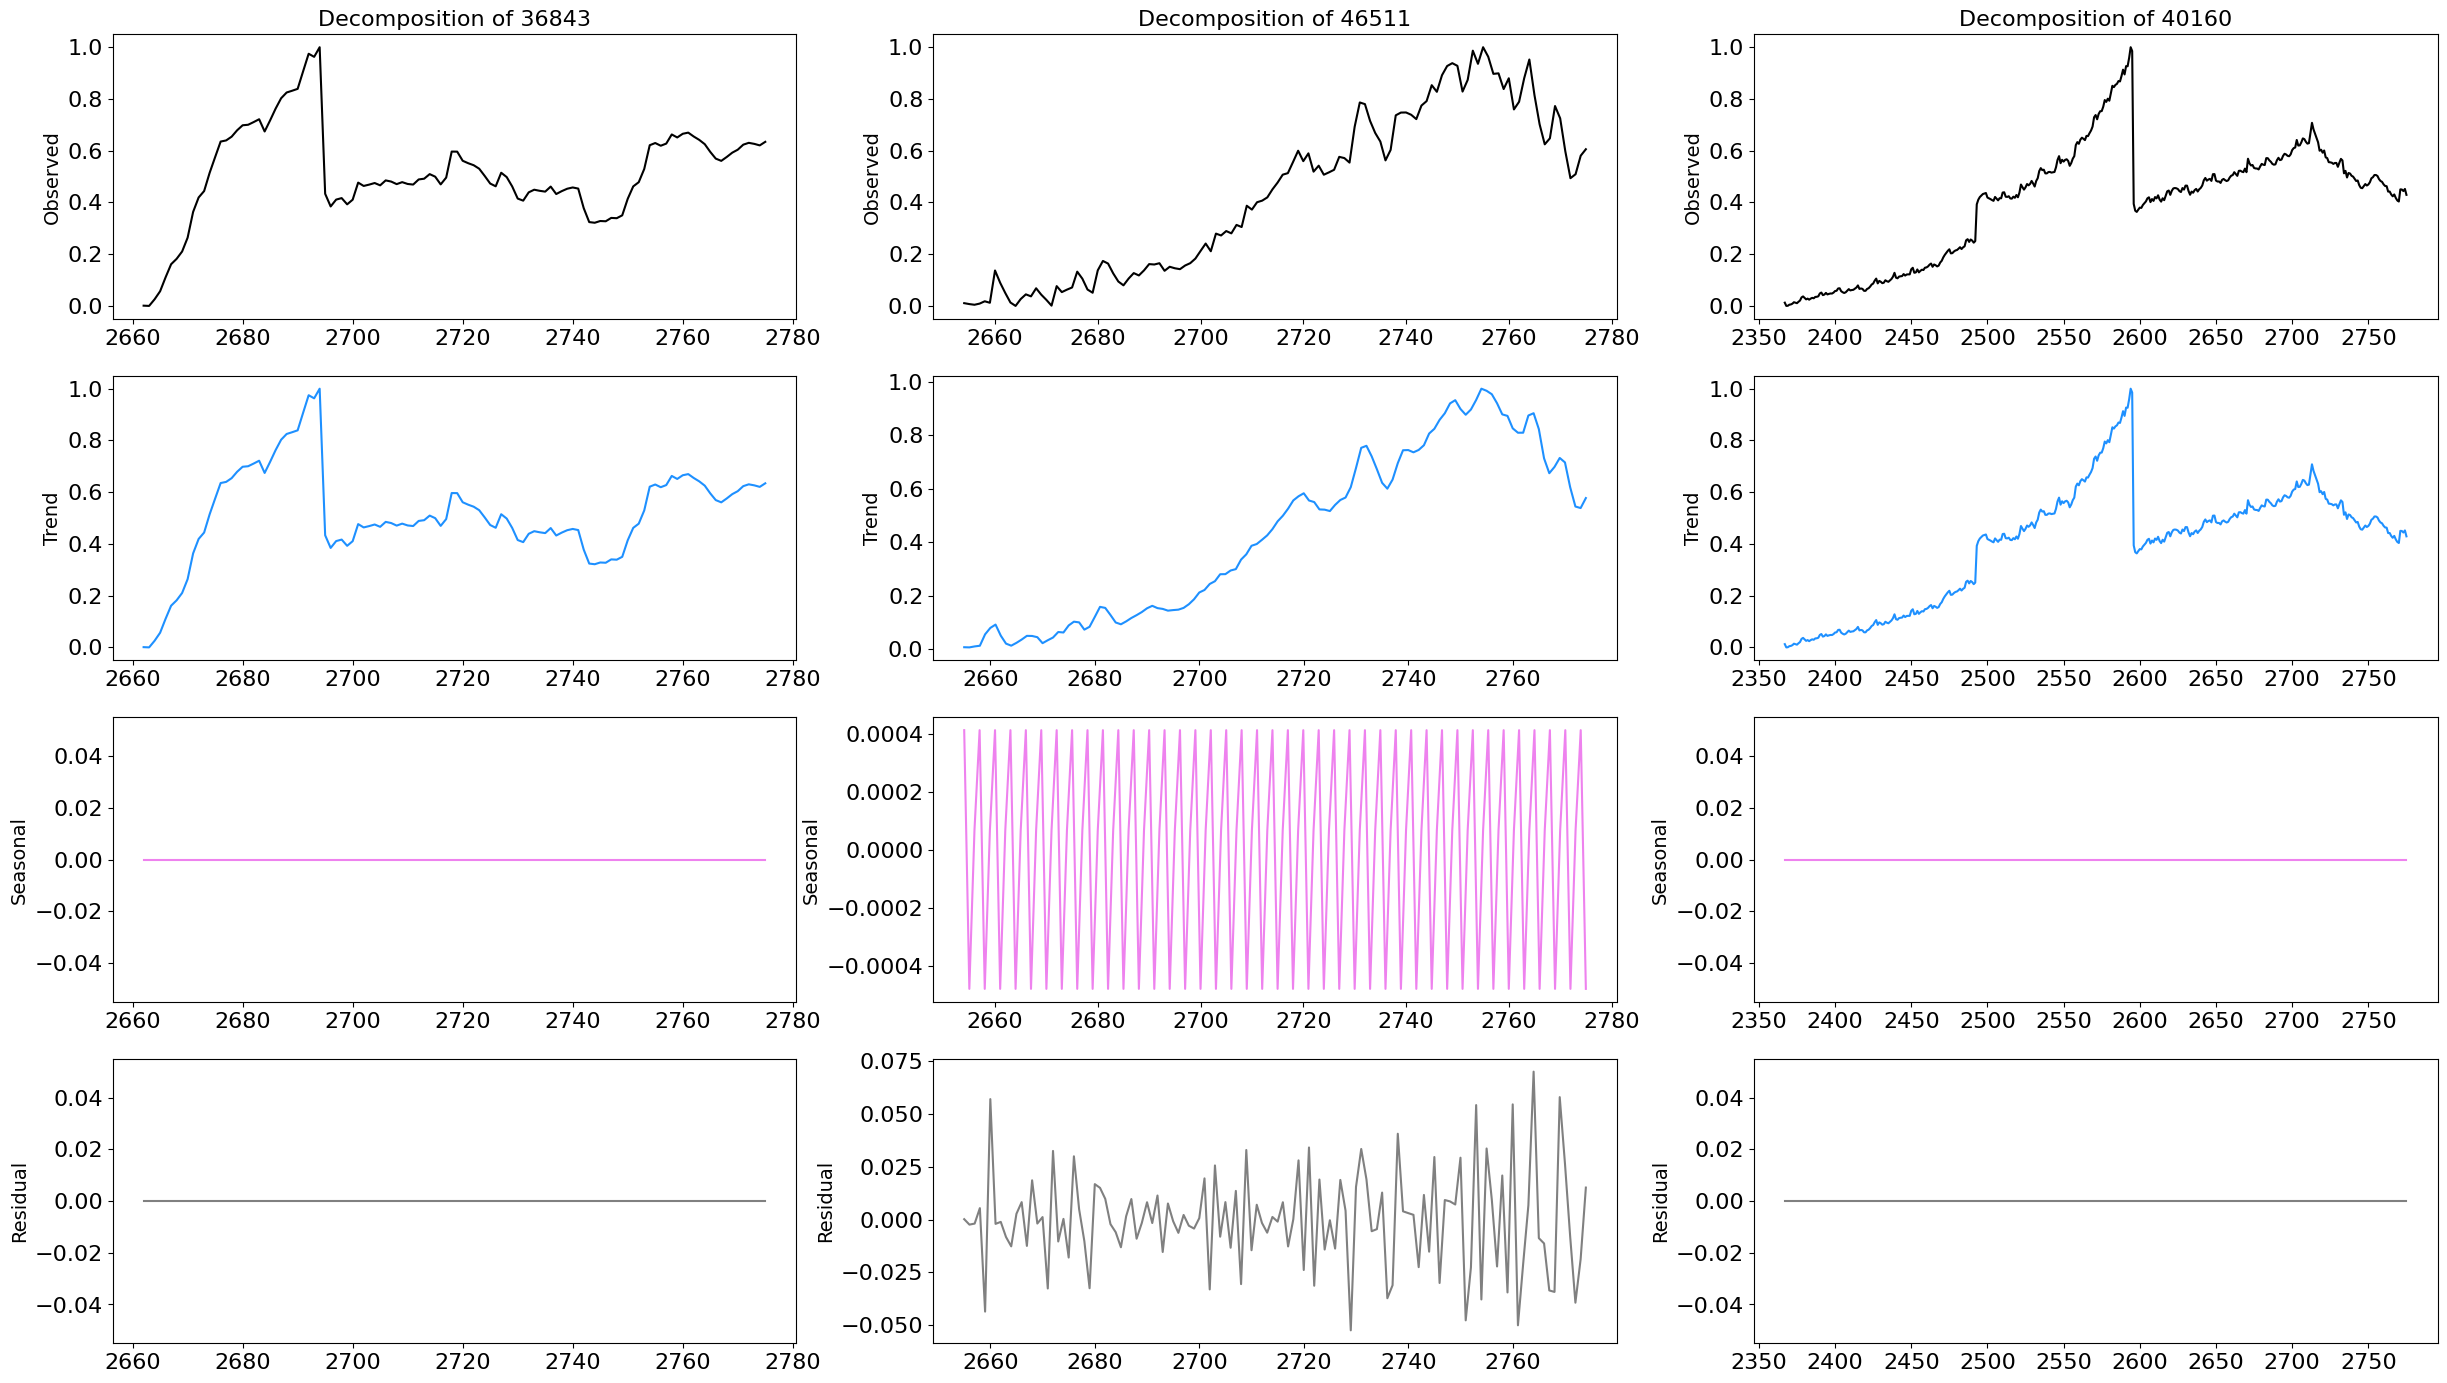

In [86]:
n_cols=3
fig, ax = plt.subplots(nrows=4, ncols=n_cols, figsize=(30,17))

for i, (idx, row) in enumerate(df_tmp[:n_cols].iterrows()):
    valid_ts = row[valid_periods[idx][0]:valid_periods[idx][1]]
    period = test_stationarity(valid_ts)[2]
    res = seasonal_decompose(valid_ts, model='additive', period=period)

    ax[0,i].set_title('Decomposition of {}'.format(idx), fontsize=16)
    # res.observed.plot(ax=ax[0, i], legend=False, color='dodgerblue')
    ax[0, i].plot(np.arange(valid_periods[idx][0], valid_periods[idx][1]), res.observed, color='black')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1, i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2, i], legend=False, color='violet')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3, i], legend=False, color='gray')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

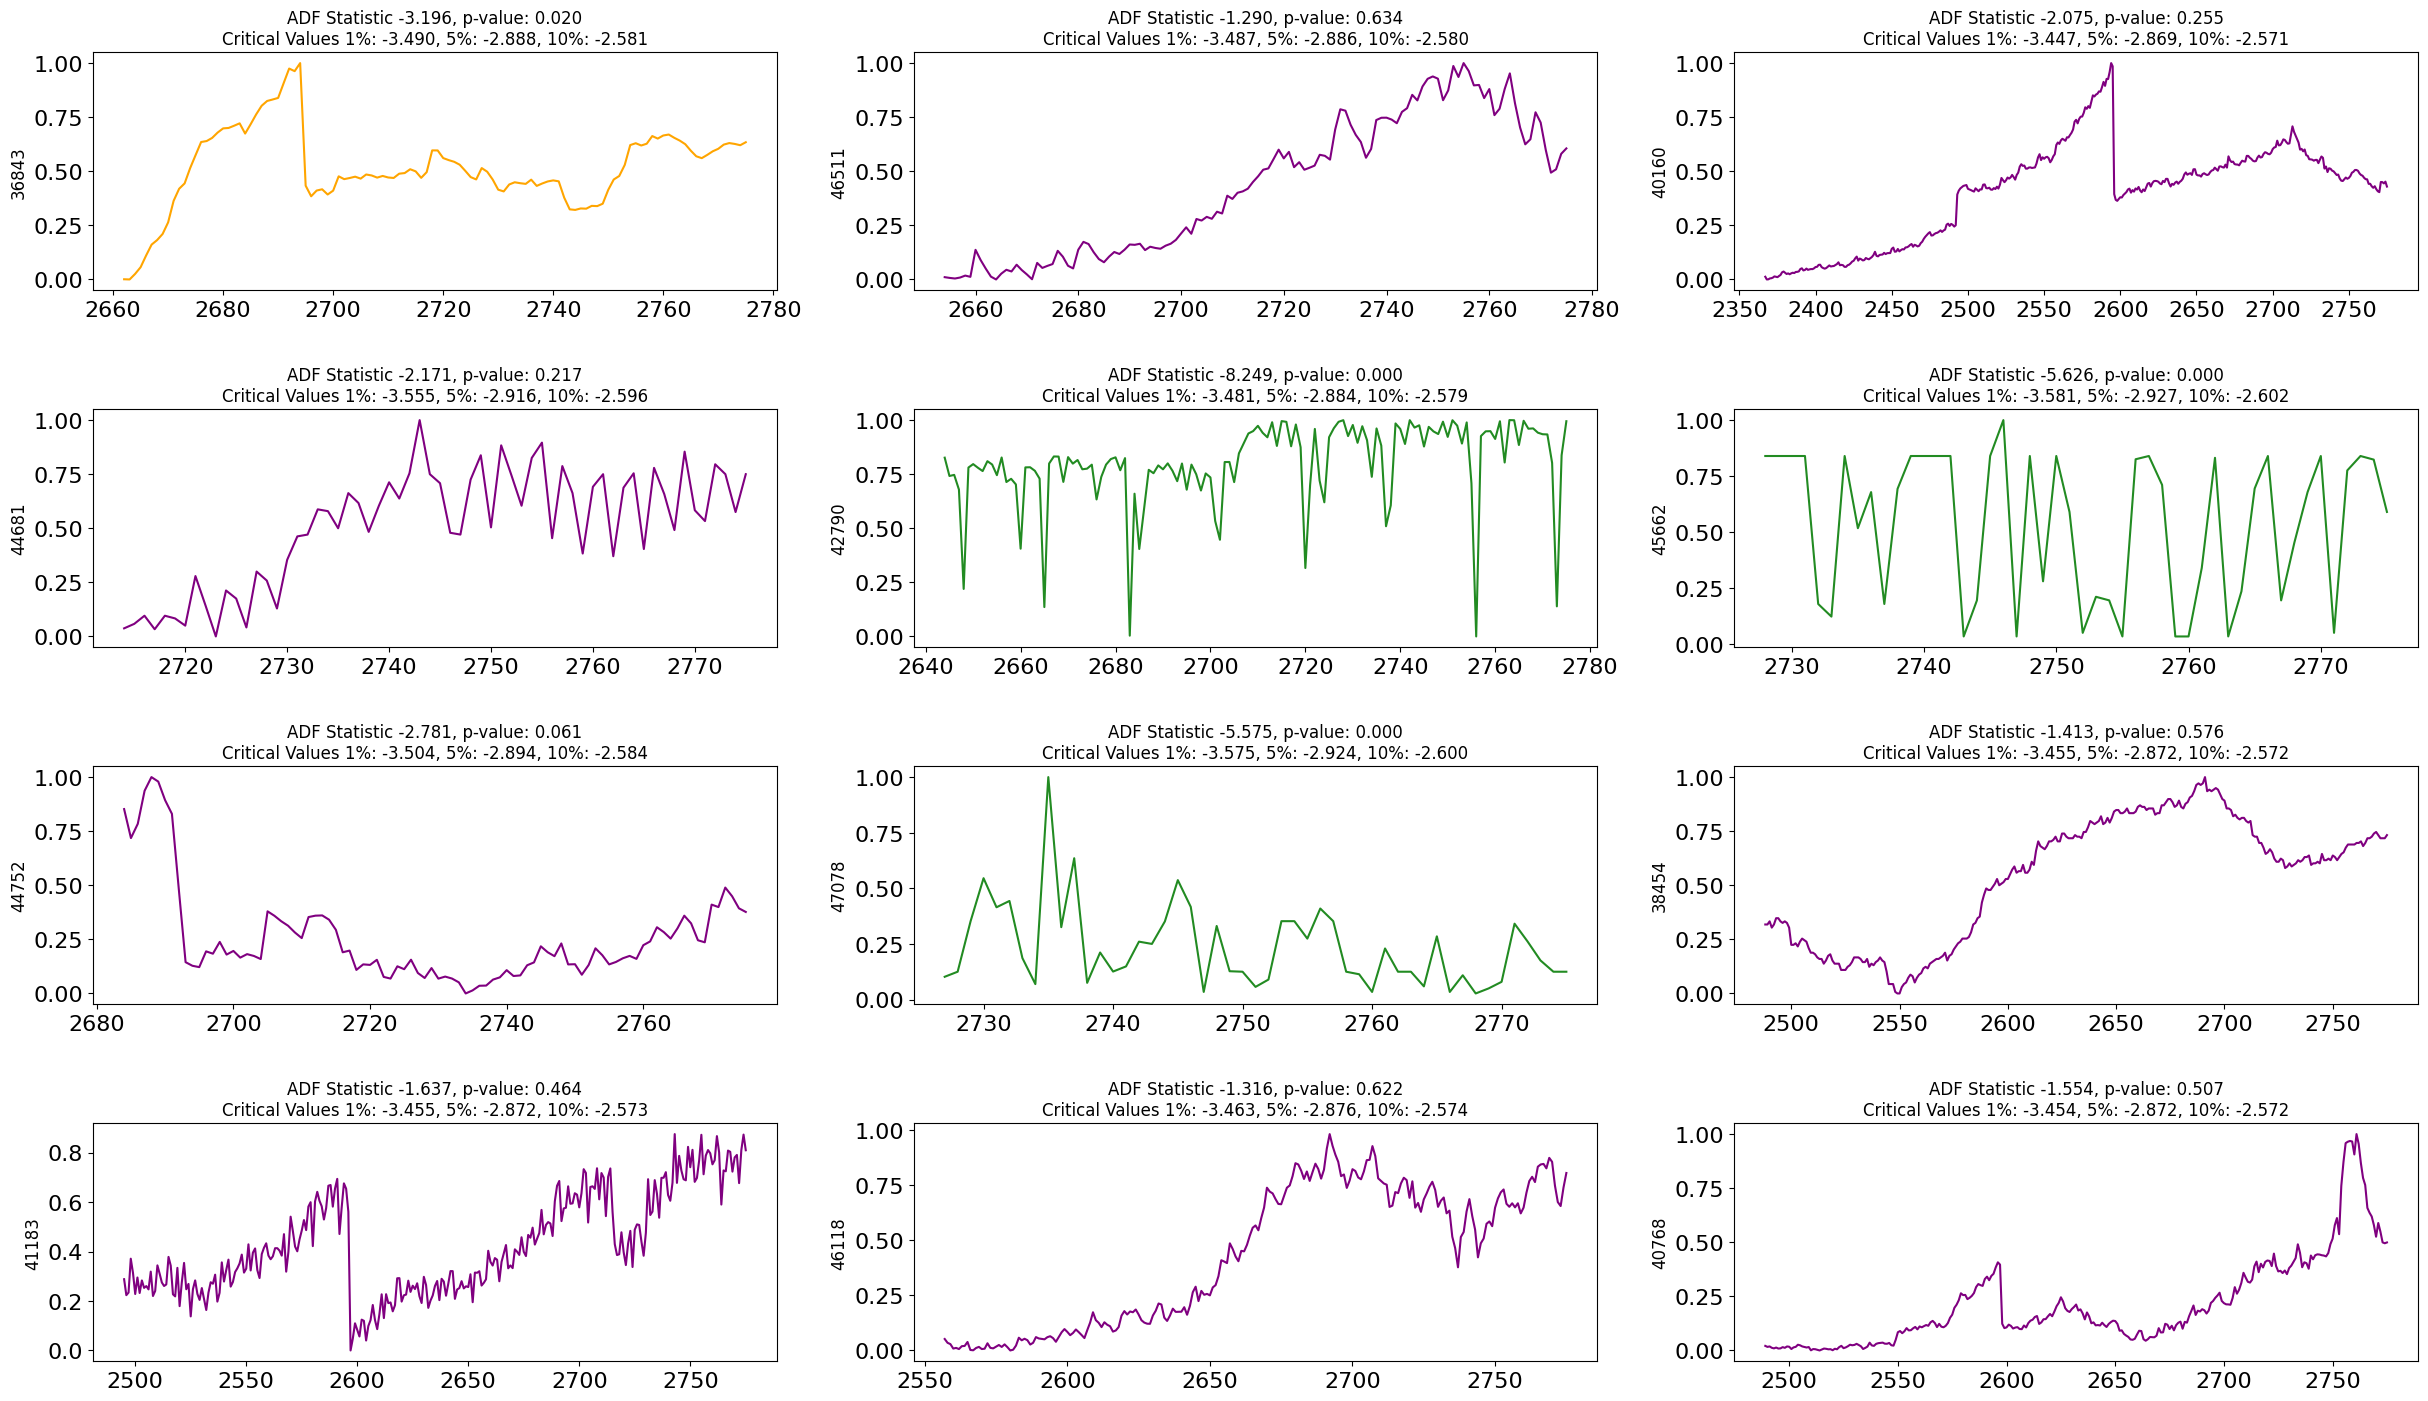

In [87]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(30, 17))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.5)

for (idx, row), ax in zip(df_tmp.iterrows(), axes):
    valid_ts = row[valid_periods[idx][0]:valid_periods[idx][1]]
    visualize_stat_results(valid_ts, idx, ax)